# Pipeline for the anomaly detection on the SKAB using LSTM-Autoencoder

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../utils')

In [4]:
import pandas as pd
import numpy as np

def evaluating_change_point(true, prediction, metric='nab', numenta_time=None):
    """
    true - both:
                list of pandas Series with binary int labels
                pandas Series with binary int labels
    prediction - both:
                      list of pandas Series with binary int labels
                      pandas Series with binary int labels
    metric: 'nab', 'binary' (FAR, MAR), 'average_delay'
                
    """
    
    def binary(true, prediction):      
        """
        true - true binary series with 1 as anomalies
        prediction - trupredicted binary series with 1 as anomalies
        """
        def single_binary(true,prediction):
            true_ = true == 1 
            prediction_ = prediction == 1
            TP = (true_ & prediction_).sum()
            TN = (~true_ & ~prediction_).sum()
            FP = (~true_ & prediction_).sum()
            FN = (true_ & ~prediction_).sum()
            return TP,TN,FP,FN
            
        if type(true) != type(list()):
            TP,TN,FP,FN = single_binary(true,prediction)
        else:
            TP,TN,FP,FN = 0,0,0,0
            for i in range(len(true)):
                TP_,TN_,FP_,FN_ = single_binary(true[i],prediction[i])
                TP,TN,FP,FN = TP+TP_,TN+TN_,FP+FP_,FN+FN_       
    
        f1 = round(TP/(TP+(FN+FP)/2), 2)
        print(f'False Alarm Rate {round(FP/(FP+TN)*100,2)} %' )
        print(f'Missing Alarm Rate {round(FN/(FN+TP)*100,2)} %')
        print(f'F1 metric {f1}')
        return f1
    
    def average_delay(detecting_boundaries, prediction):
        
        def single_average_delay(detecting_boundaries, prediction):
            missing = 0
            detectHistory = []
            for couple in detecting_boundaries:
                t1 = couple[0]
                t2 = couple[1]
                if prediction[t1:t2].sum()==0:
                    missing+=1
                else:
                    detectHistory.append(prediction[prediction ==1][t1:t2].index[0]-t1)
            return missing, detectHistory
            
        
        if type(prediction) != type(list()):
            missing, detectHistory = single_average_delay(detecting_boundaries, prediction)
        else:
            missing, detectHistory = 0, []
            for i in range(len(prediction)):
                missing_, detectHistory_ = single_average_delay(detecting_boundaries[i], prediction[i])
                missing, detectHistory = missing+missing_, detectHistory+detectHistory_

        add = pd.Series(detectHistory).mean()
        print('Average delay', add)
        print(f'A number of missed CPs = {missing}')
        return add
    
    def evaluate_nab(detecting_boundaries, prediction, table_of_coef=None):
        """
        Scoring labeled time series by means of
        Numenta Anomaly Benchmark methodics
        Parameters
        ----------
        detecting_boundaries: list of list of two float values
            The list of lists of left and right boundary indices
            for scoring results of labeling
        prediction: pd.Series with timestamp indices, in which 1 
            is change point, and 0 in other case. 
        table_of_coef: pandas array (3x4) of float values
            Table of coefficients for NAB score function
            indeces: 'Standart','LowFP','LowFN'
            columns:'A_tp','A_fp','A_tn','A_fn'
        Returns
        -------
        Scores: numpy array, shape of 3, float
            Score for 'Standart','LowFP','LowFN' profile 
        Scores_null: numpy array, shape 3, float
            Null score for 'Standart','LowFP','LowFN' profile             
        Scores_perfect: numpy array, shape 3, float
            Perfect Score for 'Standart','LowFP','LowFN' profile  
        """
        def single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=None, name_of_dataset=None):
            if table_of_coef is None:
                table_of_coef = pd.DataFrame([[1.0,-0.11,1.0,-1.0],
                                     [1.0,-0.22,1.0,-1.0],
                                      [1.0,-0.11,1.0,-2.0]])
                table_of_coef.index = ['Standart','LowFP','LowFN']
                table_of_coef.index.name = "Metric"
                table_of_coef.columns = ['A_tp','A_fp','A_tn','A_fn']

            alist = detecting_boundaries.copy()
            prediction = prediction.copy()

            Scores, Scores_perfect, Scores_null=[], [], []
            for profile in ['Standart', 'LowFP', 'LowFN']:       
                A_tp = table_of_coef['A_tp'][profile]
                A_fp = table_of_coef['A_fp'][profile]
                A_fn = table_of_coef['A_fn'][profile]
                def sigm_scale(y, A_tp, A_fp, window=1):
                    return (A_tp-A_fp)*(1/(1+np.exp(5*y/window))) + A_fp

                #First part
                score = 0
                if len(alist)>0:
                    score += prediction[:alist[0][0]].sum()*A_fp
                else:
                    score += prediction.sum()*A_fp
                #second part
                for i in range(len(alist)):
                    if i<=len(alist)-2:
                        win_space = prediction[alist[i][0]:alist[i+1][0]].copy()
                    else:
                        win_space = prediction[alist[i][0]:].copy()
                    win_fault = prediction[alist[i][0]:alist[i][1]]
                    slow_width = int(len(win_fault)/4)

                    if len(win_fault) + slow_width >= len(win_space):
                        print(f'Intersection of the windows of too wide widths for dataset {name_of_dataset}')
                        win_fault_slow = win_fault.copy()
                    else:
                        win_fault_slow= win_space[:len(win_fault)  +  slow_width]

                    win_fp = win_space[-len(win_fault_slow):]

                    if win_fault_slow.sum() == 0:
                        score+=A_fn
                    else:
                        #to get the first index
                        tr = pd.Series(win_fault_slow.values,index = range(-len(win_fault), len(win_fault_slow)-len(win_fault)))
                        tr_values= tr[tr==1].index[0]
                        tr_score = sigm_scale(tr_values, A_tp,A_fp,slow_width)
                        score += tr_score
                        score += win_fp.sum()*A_fp
                Scores.append(score)
                Scores_perfect.append(len(alist)*A_tp)
                Scores_null.append(len(alist)*A_fn)
            return np.array([np.array(Scores),np.array(Scores_null), np.array(Scores_perfect)])
       #======      
        if type(prediction) != type(list()):
            matrix = single_evaluate_nab(detecting_boundaries, prediction, table_of_coef=table_of_coef)
        else:
            matrix = np.zeros((3,3))
            for i in range(len(prediction)):
                matrix_ = single_evaluate_nab(detecting_boundaries[i], prediction[i], table_of_coef=table_of_coef,name_of_dataset=i)
                matrix = matrix + matrix_      
                
        results = {}
        desc = ['Standart', 'LowFP', 'LowFN'] 
        for t, profile_name in enumerate(desc):
            results[profile_name] = round(100*(matrix[0,t]-matrix[1,t])/(matrix[2,t]-matrix[1,t]), 2)
            print(profile_name,' - ', results[profile_name])
        
        return results
            
            
    #=========================================================================
    if type(true) != type(list()):
        true_items = true[true==1].index
    else:
        true_items = [true[i][true[i]==1].index for i in range(len(true))]
        

    if not metric=='binary':
        def single_detecting_boundaries(true, numenta_time, true_items):
            detecting_boundaries=[]
            td = pd.Timedelta(numenta_time) if numenta_time is not None else pd.Timedelta((true.index[-1]-true.index[0])/len(true_items))  
            for val in true_items:
                detecting_boundaries.append([val, val + td])
            return detecting_boundaries
        
        if type(true) != type(list()):
            detecting_boundaries = single_detecting_boundaries(true=true, numenta_time=numenta_time, true_items=true_items)
        else:
            detecting_boundaries=[]
            for i in range(len(true)):
                detecting_boundaries.append(single_detecting_boundaries(true=true[i], numenta_time=numenta_time, true_items=true_items[i]))

    if metric== 'nab':
        return evaluate_nab(detecting_boundaries, prediction)
    elif metric=='average_delay':
        return average_delay(detecting_boundaries, prediction)
    elif metric== 'binary':
        return binary(true, prediction)

## Data loading

In [5]:
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [6]:
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

## Data description and visualization

## Labels

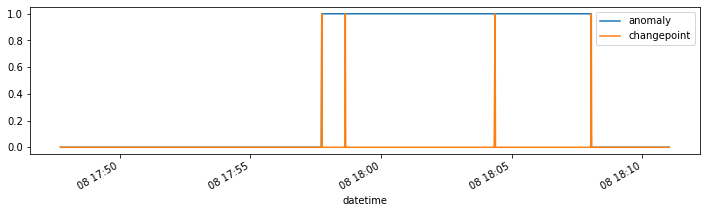

In [8]:
list_of_df[1].anomaly.plot(figsize=(12,3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [9]:
# libraries importing
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [10]:
def Random(seed_value):
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    import random
    random.seed(seed_value)
    import numpy as np
    np.random.seed(seed_value)
    import tensorflow as tf
    tf.random.set_seed(seed_value)

In [12]:
def arch(data):
    EPOCHS = 200
    BATCH_SIZE = 128
    VAL_SPLIT = 0.2
    Random(0)    
    inputs = keras.Input(shape=(data.shape[1], data.shape[2]))
    encoded = layers.LSTM(100, activation='relu')(inputs)

    decoded = layers.RepeatVector(data.shape[1])(encoded)
    decoded = layers.LSTM(100, activation='relu', return_sequences=True)(decoded)
    decoded = layers.TimeDistributed(layers.Dense(data.shape[2]))(decoded)

    model = keras.Model(inputs, decoded)
    encoder = keras.Model(inputs, encoded)

    model.compile(optimizer='adam', loss='mae', metrics=["mse"])
    
    early_stopping = EarlyStopping(patience=5, verbose=0)
    
    history = model.fit(data, data,
                        validation_split=VAL_SPLIT,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=0,
                        shuffle=False
                        )
    return history, model

### Training in the beginning of each dataset

In [15]:
def create_sequences(values, time_steps=N_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [16]:
%%time
N_STEPS = 30
Q = 0.8

predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    StSc = StandardScaler()
    StSc.fit(X_train)
    X = create_sequences(StSc.transform(X_train), N_STEPS)
    
    history, model = arch(X)
    
    residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    UCL = residuals.quantile(Q)
    
    X = create_sequences(StSc.transform(df.drop(['anomaly','changepoint'], axis=1)), N_STEPS)
    cnn_residuals = pd.Series(np.sum(np.mean(np.abs(X - model.predict(X)), axis=1), axis=1))
    
    anomalous_data = cnn_residuals > (3/2 * UCL)
    anomalous_data_indices = []
    for data_idx in range(N_STEPS - 1, len(X) - N_STEPS + 1):
        if np.all(anomalous_data[data_idx - N_STEPS + 1 : data_idx]):
            anomalous_data_indices.append(data_idx)
    prediction = pd.Series(data=0, index=df.index)
    prediction.iloc[anomalous_data_indices] = 1
    predicted_outlier.append(prediction)
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

KeyboardInterrupt: 

### Results

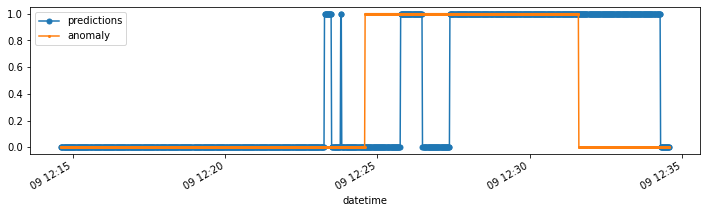

In [50]:
true_outlier = [df.anomaly for df in list_of_df]
predicted_outlier[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[0].plot(marker='o', markersize=2)
plt.legend();

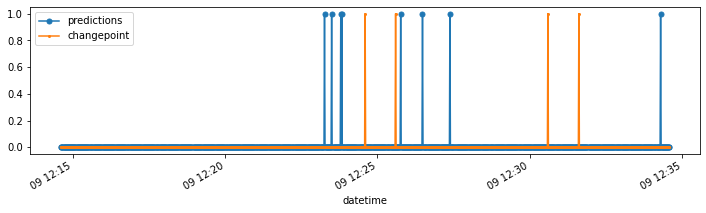

In [51]:
true_cp = [df.changepoint for df in list_of_df]
predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Metrics calculation

In [52]:
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 14.24 %
Missing Alarm Rate 35.56 %
F1 metric 0.68


## [Additional] localization